In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import numpy as np

In [2]:
def initialize():
    pass 

In [3]:
def aggregate_data(df, suffix, time_window):
    # Create new columns with initial NaN values
    temp_cols = ['TemperatureDelta', 'TotalCoolingPower', 'TotalHeatingPower']
    for col in temp_cols:
        df[f'{col}{suffix}'] = np.nan

    # Loop through the dataframe in chunks of 'time_window'
    for start in range(0, len(df), time_window):
        end = start + time_window
        mean_values = df.iloc[start:end].mean()
        for col in temp_cols:
            df.loc[start:end, f'{col}{suffix}'] = mean_values[col]

    return df

In [17]:
def daily_data(df, delta_temp, cooling_power, heating_power):
    suffix = '_Day'
    for day in range(730):
        day_slice = slice(day * 24, (day + 1) * 24) # Define a slice for one day (24 hours)
        if day == 729:
            day_slice = slice(day * 24, None) # Handle the last day separately
        # Calculate and assign daily mean values
        df[f'{delta_temp}{suffix}'] = df[delta_temp][day_slice].mean()
        df[f'{cooling_power}{suffix}'] = df[cooling_power][day_slice].mean()
        df[f'{heating_power}{suffix}'] = df[heating_power][day_slice].mean()


def weekly_data(df, delta_temp, cooling_power, heating_power):
    suffix = '_Week'
    for week in range(104):
        week_slice = slice(week * 168, (week + 1) * 168) # Define a slice for one week (168 hours)
        if week == 103:
            week_slice = slice(week * 168, None) # Handle the last week separately
        # Calculate and assign weekly mean values
        df[f'{delta_temp}{suffix}'] = df[delta_temp][week_slice].mean()
        df[f'{cooling_power}{suffix}'] = df[cooling_power][week_slice].mean()
        df[f'{heating_power}{suffix}'] = df[heating_power][week_slice].mean()

def monthly_data(df, delta_temp, cooling_power, heating_power):
    suffix = '_Month'
    for month in range(24):
        month_slice = slice(month * 730, (month + 1) * 730)  # Define a slice for one month
        if month == 23:
            month_slice = slice(month * 730, None) # Handle the last month separately
        # Calculate and assign monthly mean values
        df[f'{delta_temp}{suffix}'] = df[delta_temp][month_slice].mean()
        df[f'{cooling_power}{suffix}'] = df[cooling_power][month_slice].mean()
        df[f'{heating_power}{suffix}'] = df[heating_power][month_slice].mean()

def season_data(df, season=''):
    # Concatenate data for winter and summer periods
    winter_data = pd.concat([df[:1776+744], df[7296:10533+744], df[16053:]])
    summer_data = pd.concat([df[1776+744:7295], df[10533+744:16053]])
    # Filter out rows with insignificant power values
    winter_data = winter_data[winter_data[f'TotalHeatingPower{season}'] > 0.1]
    summer_data = summer_data[summer_data[f'TotalCoolingPower{season}'] > 0.1]
    return winter_data, summer_data

In [5]:
def load_and_prepare_data(filepath1, filepath2):
    # Load data from the provided CSV files
    data1 = pd.read_csv(filepath1, sep=',', decimal=',', index_col=0, low_memory=False)
    data2 = pd.read_csv(filepath2, sep=',', decimal=',', index_col=0, low_memory=False)
    combined_data = pd.concat([data1, data2])
    
    # Convert specified columns to float
    columns_to_convert = ['DistrictCoolingFacility', 'DistrictHeatingFacility', 'ElectricityFacility']
    for col in columns_to_convert:
        combined_data[col] = combined_data[col].astype(float)
    
    # Calculate total cooling and heating power
    combined_data['TotalCoolingPower'] = combined_data['DistrictCoolingFacility'] / 3.6e6
    combined_data['TotalHeatingPower'] = combined_data['DistrictHeatingFacility'] / 3.6e6
    combined_data['ExternalTemp'] = combined_data['DrybulbTemperatureHourly'].astype(float)

    # Convert operative temperatures to float and calculate internal temperature
    operative_temps = [f"ZONE{i}OperativeTemperature" for i in range(1, 13) if i != 9]
    for temp in operative_temps:
        combined_data[temp] = combined_data[temp].astype(float)
    
    combined_data['InternalTemp'] = combined_data[operative_temps].mean(axis=1) # Calculate the mean internal temperature
    combined_data['TemperatureDelta'] = combined_data['InternalTemp'] - combined_data['ExternalTemp'] # Calculate the temperature delta

    combined_data.dropna(inplace=True) # Drop rows with any NaN values

    for attr in ['TemperatureDelta', 'TotalCoolingPower', 'TotalHeatingPower']:
        combined_data[attr] = np.array(combined_data[attr], dtype=float)
    
    daily_data(combined_data, 'TemperatureDelta', 'TotalCoolingPower', 'TotalHeatingPower')
    weekly_data(combined_data, 'TemperatureDelta', 'TotalCoolingPower', 'TotalHeatingPower')
    monthly_data(combined_data, 'TemperatureDelta', 'TotalCoolingPower', 'TotalHeatingPower')

    return combined_data

In [6]:
def plot_energy_signature(df_winter, df_summer, label_suffix=''):
    plt.figure()
    plt.grid()
    plt.title('Energy Signature Analysis')
    plt.xlabel("Temperature Difference [°C]")
    plt.ylabel("Energy Consumption [kWh]")
    
    # Plot regression lines and scatter plots for winter heating and summer cooling
    plot_regression(df_winter, 'TotalHeatingPower', label_suffix, 'blue', 'red')
    plot_regression(df_summer, 'TotalCoolingPower', label_suffix, 'green', 'orange')
    plt.legend(loc='upper center', fontsize=8)
    plt.ylim(0)
    plt.savefig(f'Energy_Signature_{label_suffix}.png', dpi=600)
    plt.show()

def plot_regression(df, power_type, label_suffix, line_color, scatter_color):
    independent_var = 'TemperatureDelta' + label_suffix
    dependent_var = power_type + label_suffix
    X = sm.add_constant(df[independent_var]) # Add a constant term for the regression
    model = sm.OLS(df[dependent_var], X) # Create an ordinary least squares (OLS) regression model
    results = model.fit()
    print(f"### RESULTS FOR {power_type.upper()} REGRESSION {label_suffix}")
    print(results.summary())
    
    plt.plot(df[independent_var], results.predict(), label=f"{power_type.title()} Regression Line", color=line_color)
    plt.scatter(df[independent_var], df[dependent_var], s=5, label=f"{power_type.title()} Samples", color=scatter_color)

In [18]:
file1 = 'influx_eplusout2012.csv'
file2 = 'influx_eplusout2005.csv'
df_main = load_and_prepare_data(file1, file2)

### RESULTS FOR TOTALHEATINGPOWER REGRESSION 
                            OLS Regression Results                            
Dep. Variable:      TotalHeatingPower   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     2458.
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        10:52:27   Log-Likelihood:                -6895.9
No. Observations:                4705   AIC:                         1.380e+04
Df Residuals:                    4703   BIC:                         1.381e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

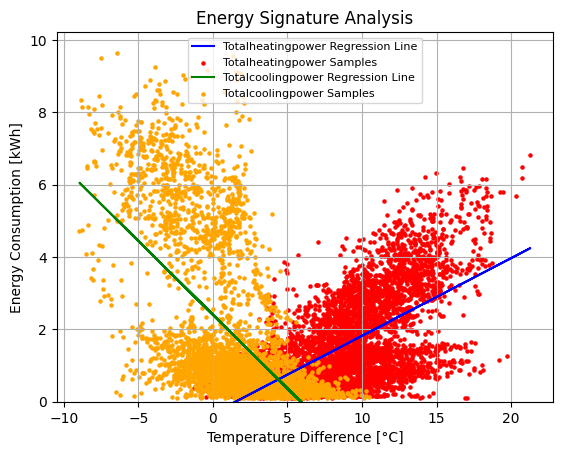

In [8]:
winter, summer = season_data(df_main)
plot_energy_signature(winter, summer)

### RESULTS FOR TOTALCOOLINGPOWER REGRESSION_D
                            OLS Regression Results                            
Dep. Variable:          TotalPower2_D   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     7401.
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        11:18:40   Log-Likelihood:                -5334.1
No. Observations:                7967   AIC:                         1.067e+04
Df Residuals:                    7965   BIC:                         1.069e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

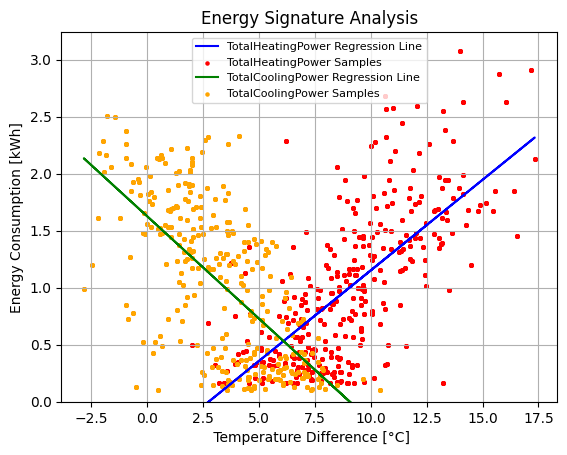

In [ ]:
winter, summer = daily_data(df_main)
plot_energy_signature(winter, summer)

### RESULTS FOR TOTALCOOLINGPOWER REGRESSION_W
                            OLS Regression Results                            
Dep. Variable:          TotalPower2_W   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                 1.659e+04
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        11:19:07   Log-Likelihood:                -2674.6
No. Observations:                7967   AIC:                             5353.
Df Residuals:                    7965   BIC:                             5367.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

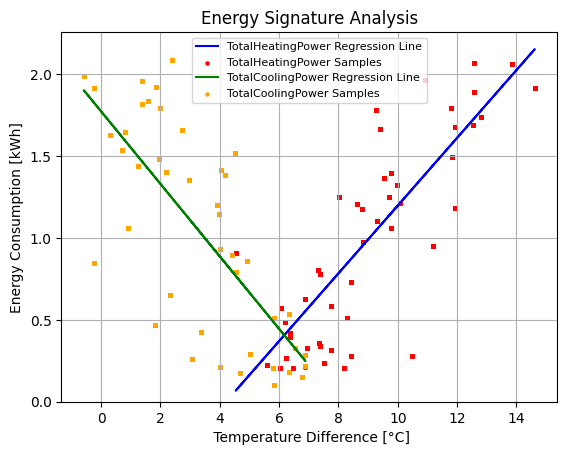

In [ ]:
winter, summer = weekly_data(df_main)
plot_energy_signature(winter, summer)

### RESULTS FOR TOTALCOOLINGPOWER REGRESSION_M
                            OLS Regression Results                            
Dep. Variable:          TotalPower2_M   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                 3.649e+04
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        11:19:34   Log-Likelihood:                 386.65
No. Observations:                7967   AIC:                            -769.3
Df Residuals:                    7965   BIC:                            -755.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

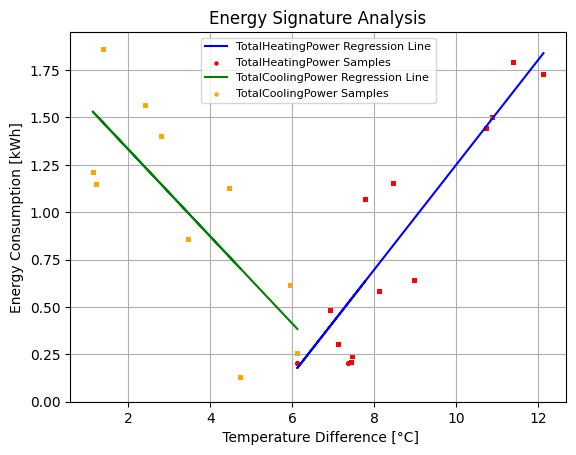

In [ ]:
winter, summer = monthly_data(df_main)
plot_energy_signature(winter, summer)